In [ ]:
# GLOBAL VARIABLES. BE SURE NOT TO OVERWRITE THEM
D = 8 # Amount of documents
V = 12 # Size of the vocabulary

# (Approximate) Maximum allowed amount of same word repetition in a document (it may be lower in practise due to the data generation strategy)
# To get the actual maximum amount, call Simulator.get_M
M = 10 


k = 5 # Amount of topics
gamma = 0.2  #

In [ ]:
# GLOBAL VARIABLES. BE SURE NOT TO OVERWRITE THEM
D = 100 # Amount of documents
V = 18 # Size of the vocabulary

# (Approximate) Maximum allowed amount of same word repetition in a document (it may be lower in practise due to the data generation strategy)
# To get the actual maximum amount, call Simulator.get_M
M = 5 

k = 6 # Amount of topics
gamma = 0.2

# FA: Since we're testing so much, lets agree on using just 1 small set of global variables for now

In [3]:
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd

From now on let's use the following simulated data for further testing

In [4]:
from simulator import Simulator

In [5]:
test_data = Simulator(D, V, M, k, gamma, seed=1967)  # Man on the moon
test_data.generate_all_data()

random_initial_data = Simulator(D, V, M, k, gamma, seed=1969)  # Woodstock Music Festival
random_initial_data.generate_all_data()

Success: Sigma transformed from K
Success: G transformed from K
Success: W and Z generated
Success: E transformed from Z
Success: C transformed from Z
Success: Sigma transformed from K
Success: G transformed from K
Success: W and Z generated
Success: E transformed from Z
Success: C transformed from Z


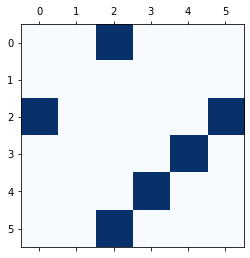

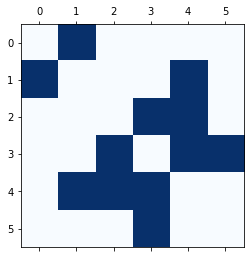

In [6]:
plt.matshow(test_data.G, cmap='Blues')
plt.matshow(random_initial_data.G, cmap='Blues')

# 2. MC SAMPLER

## 2.3.1 Sampling H (Metropolis-Hastings MC Sampling)

### Task:

You must implement a function that receives matrices $E_i$, $K_i$ and vector $\mu$ and generates the next $H_{i+1}$.


. $E$ matrix of $D \times k$ where $E_d$ is the $k$-dim vector of counts of sampled drawings for the $z$-th topic over all words for each document

. $K$ matrix of $k \times k$ representing the precision matrix associated to the graph $G$

. $\mu = 0$

. $H$ matrix of $D \times k$ where $H_d = \eta_d$ is the $k$-dim vector of the topic prevalences over document $d$

In [24]:
from samplers import MC_sample_H

## 2.3.2 H Sampling Tests

In [65]:
step_size = 0.25
E_copy = test_data.E.copy()
Sigma_copy = test_data.Sigma.copy()
K_copy = test_data.K.copy()

H_sample, step_size = MC_sample_H(E_copy, Sigma_copy, K_copy, step_size=step_size,
                                 adaptive_step_ratio=1.5, adaptive_step_threshold=0.55, max_step=0.25)

assert np.all(E_copy == test_data.E)
assert np.all(Sigma_copy == test_data.Sigma)

In [ ]:
%%time
# Check that the Sampler works properly (This will take... forever)
errors = []
matrix_changes = []
burn_in = 1000
step_size = 0.25
steps = []

for i in range(5000):
    H_sample_old = H_sample.copy()
    H_sample, step_size = MC_sample_H(E_copy, Sigma_copy, K_copy, step_size=step_size,
                                 adaptive_step_ratio=1.5, adaptive_step_threshold=0.55, max_step=0.25)
    matrix_changes.append(~np.all(H_sample_old == H_sample))
    if i >= burn_in:
        errors.append(np.linalg.norm(H_sample - test_data.H))  # Computing error wrt the target matrix
        steps.append(step_size)

In [ ]:
# Matrix should change
matrix_changes = pd.Series(matrix_changes).astype(int)
print("Matrix changes (1 = changed, 0 = same)")

print(matrix_changes.describe())
matrix_changes.hist(bins=30)

In [ ]:
# Error should be distributed close to 0 (I guess...)  # BUG https://trello.com/c/9k2e8PQz/33-mcsampleh-is-not-close-to-expected-target
errors = pd.Series(errors)
print("H L2-error metrics")
print(errors.describe())
errors.hist(bins=30)

In [ ]:
errors.plot()
print("H L2-error series")

In [ ]:
# Matrix should change
steps = pd.Series(steps)
print("Steps")

print(steps.describe())
steps.hist(bins=30)

In [ ]:
steps.plot()
print("Steps")

As you can see, the true (left) and the last sampled (center) $\Theta$ are quite similar. The right heatmap represents the difference of the first two. 


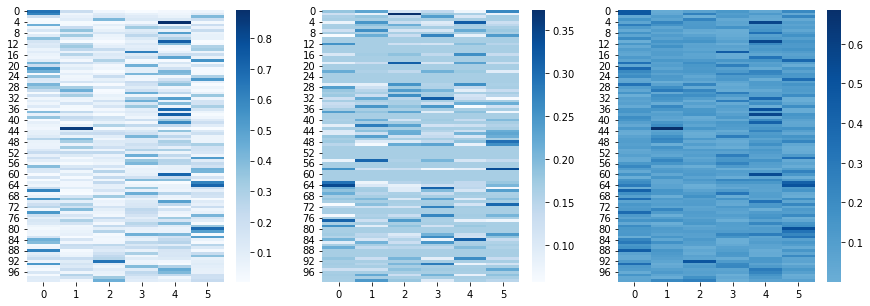

3.7431689993988524

In [64]:
import seaborn as sn
from transformation_functions import update_Theta


fig, ax = plt.subplots(1,3, figsize=(15, 5))

last_Theta = update_Theta(np.zeros(H_sample.shape), H_sample)
true_Theta = update_Theta(np.zeros(H_sample.shape), test_data.H)

sn.heatmap(true_Theta, cmap='Blues',ax=ax[0])
sn.heatmap(last_Theta, cmap='Blues',ax=ax[1])
sn.heatmap(abs(true_Theta - last_Theta),cmap='Blues',ax=ax[2],center=0)
plt.show()

np.linalg.norm(true_Theta-last_Theta)

# OLD CODE, JUST KEEPING IT HERE FOR REFERENCE (for now)

## 2.3.2 H Sampling Tests (burn-in 10)

In [15]:
E_copy = test_data.E.copy()
Sigma_copy = test_data.Sigma.copy()
K_copy = test_data.K.copy()

H_sample = MC_sample_H(E_copy, Sigma_copy, K_copy)

assert np.all(E_copy == test_data.E)
assert np.all(Sigma_copy == test_data.Sigma)

In [16]:
%%time
# Check that the Sampler works properly (This will take... forever)
errors = []
matrix_changes = []
burn_in = 100

for i in range(500):
    H_sample_old = H_sample.copy()
    H_sample = MC_sample_H(E_copy, Sigma_copy, K_copy, H_sample_old, burn_in=10)
    matrix_changes.append(~np.all(H_sample_old == H_sample))
    if i >= burn_in:
        errors.append(np.linalg.norm(H_sample - test_data.H))  # Computing error wrt the target matrix

CPU times: user 50.3 s, sys: 0 ns, total: 50.3 s
Wall time: 50.3 s


Matrix changes (1 = changed, 0 = same)
count    500.0
mean       0.0
std        0.0
min        0.0
25%        0.0
50%        0.0
75%        0.0
max        0.0
dtype: float64


<AxesSubplot:>

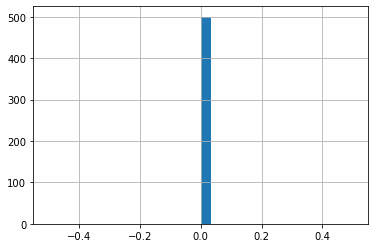

In [17]:
# Matrix should change
matrix_changes = pd.Series(matrix_changes).astype(int)
print("Matrix changes (1 = changed, 0 = same)")

print(matrix_changes.describe())
matrix_changes.hist(bins=30)

H L2-error metrics
count    400.000000
mean      25.190237
std        0.278639
min       24.344238
25%       25.003644
50%       25.209224
75%       25.383903
max       26.191396
dtype: float64


<AxesSubplot:>

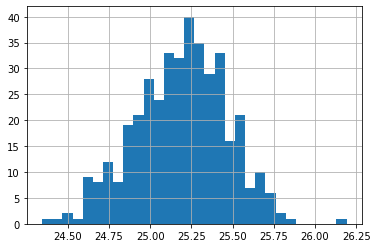

In [18]:
# Error should be distributed close to 0 (I guess...)  # BUG https://trello.com/c/9k2e8PQz/33-mcsampleh-is-not-close-to-expected-target
errors = pd.Series(errors)
print("H L2-error metrics")
print(errors.describe())
errors.hist(bins=30)

H L2-error series


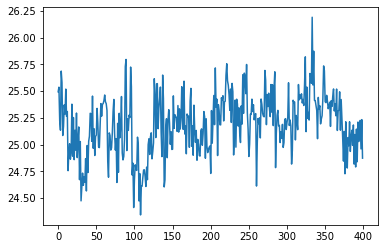

In [19]:
errors.plot()
print("H L2-error series")

As you can see, the true (left) and the last sampled (center) $\Theta$ are quite similar. The right heatmap represents the difference of the first two. 


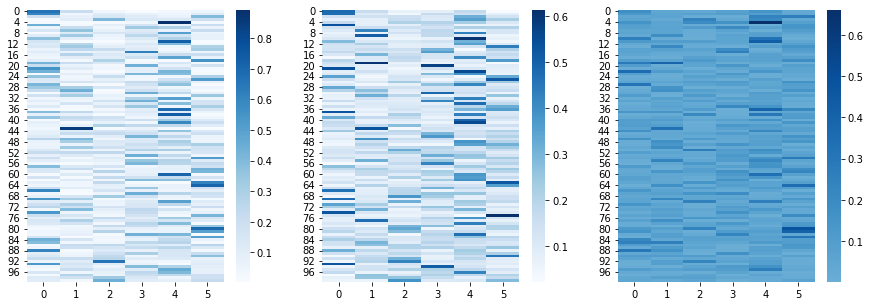

2.6708082921178327

In [20]:
import seaborn as sn
from transformation_functions import update_Theta


fig, ax = plt.subplots(1,3, figsize=(15, 5))

last_Theta = update_Theta(np.zeros(H_sample.shape), H_sample)
true_Theta = update_Theta(np.zeros(H_sample.shape), test_data.H)

sn.heatmap(true_Theta, cmap='Blues',ax=ax[0])
sn.heatmap(last_Theta, cmap='Blues',ax=ax[1])
sn.heatmap(abs(true_Theta - last_Theta),cmap='Blues',ax=ax[2],center=0)
plt.show()

np.linalg.norm(true_Theta-last_Theta)

## 2.3.2 H Sampling Tests (burn-in 100)

In [21]:
E_copy = test_data.E.copy()
Sigma_copy = test_data.Sigma.copy()
K_copy = test_data.K.copy()

H_sample = MC_sample_H(E_copy, Sigma_copy, K_copy)

assert np.all(E_copy == test_data.E)
assert np.all(Sigma_copy == test_data.Sigma)

In [22]:
%%time
# Check that the Sampler works properly (This will take... forever)
errors = []
matrix_changes = []
burn_in = 100

for i in range(500):
    H_sample_old = H_sample.copy()
    H_sample = MC_sample_H(E_copy, Sigma_copy, K_copy, H_sample_old, burn_in=100)
    matrix_changes.append(~np.all(H_sample_old == H_sample))
    if i >= burn_in:
        errors.append(np.linalg.norm(H_sample - test_data.H))  # Computing error wrt the target matrix

CPU times: user 7min 39s, sys: 47.9 ms, total: 7min 39s
Wall time: 7min 39s


Matrix changes (1 = changed, 0 = same)
count    500.0
mean       0.0
std        0.0
min        0.0
25%        0.0
50%        0.0
75%        0.0
max        0.0
dtype: float64


<AxesSubplot:>

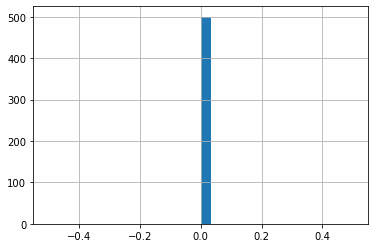

In [23]:
# Matrix should change
matrix_changes = pd.Series(matrix_changes).astype(int)
print("Matrix changes (1 = changed, 0 = same)")

print(matrix_changes.describe())
matrix_changes.hist(bins=30)

H L2-error metrics
count    400.000000
mean      25.671826
std        0.311893
min       24.476015
25%       25.478891
50%       25.681204
75%       25.862003
max       26.549296
dtype: float64


<AxesSubplot:>

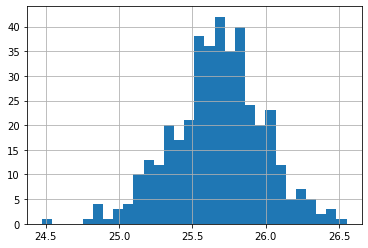

In [24]:
# Error should be distributed close to 0 (I guess...)  # BUG https://trello.com/c/9k2e8PQz/33-mcsampleh-is-not-close-to-expected-target
errors = pd.Series(errors)
print("H L2-error metrics")
print(errors.describe())
errors.hist(bins=30)

H L2-error series


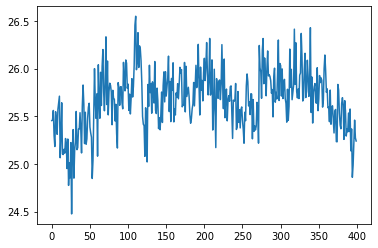

In [25]:
errors.plot()
print("H L2-error series")

As you can see, the true (left) and the last sampled (center) $\Theta$ are quite similar. The right heatmap represents the difference of the first two. 


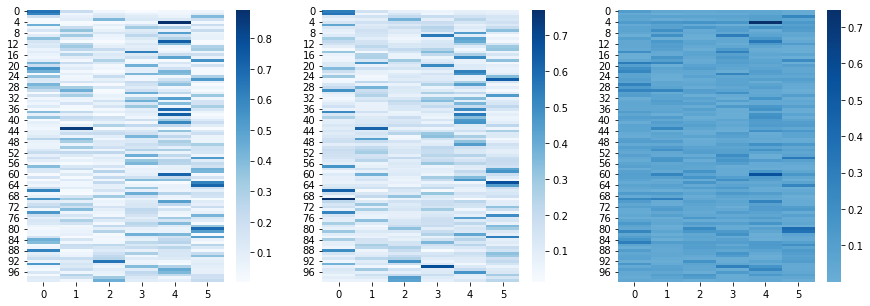

2.563571624479141

In [26]:
import seaborn as sn
from transformation_functions import update_Theta


fig, ax = plt.subplots(1,3, figsize=(15, 5))

last_Theta = update_Theta(np.zeros(H_sample.shape), H_sample)
true_Theta = update_Theta(np.zeros(H_sample.shape), test_data.H)

sn.heatmap(true_Theta, cmap='Blues',ax=ax[0])
sn.heatmap(last_Theta, cmap='Blues',ax=ax[1])
sn.heatmap(abs(true_Theta - last_Theta),cmap='Blues',ax=ax[2],center=0)
plt.show()

np.linalg.norm(true_Theta-last_Theta)